In [ ]:
!pip install networkx
!pip install imageio

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Video, display
import imageio
import os
import itertools

In [ ]:
# Step 1: Visualization
def visualize_graph_with_preferences(G, preferences, title, filename, layout):
    plt.figure(figsize=(8, 6))
    nx.draw(G, layout, with_labels=True, node_size=700, node_color="lightblue", edge_color="gray")
    labels = {node: f"{node}\nPref: {preferences.get(node, [])}" for node in G.nodes}
    nx.draw_networkx_labels(G, layout, labels)
    plt.title(title)
    plt.savefig(filename)
    plt.close()

def highlight_cycle_with_preferences(G, cycle, preferences, title, filename, layout):
    plt.figure(figsize=(8, 6))
    cycle_edges = [(cycle[i], cycle[(i+1) % len(cycle)]) for i in range(len(cycle))]
    nx.draw(G, layout, with_labels=True, node_size=700, node_color="lightblue", edge_color="gray")
    nx.draw_networkx_edges(G, layout, edgelist=cycle_edges, edge_color="red", width=2)
    labels = {node: f"{node}\nPref: {preferences.get(node, [])}" for node in G.nodes}
    nx.draw_networkx_labels(G, layout, labels)
    plt.title(title)
    plt.savefig(filename)
    plt.close()

# Step 2: TTC Algorithm with Correct Graph Handling
def ttc_algorithm(V, A, preferences, video_name="ttc_algorithm.mp4"):
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(A)

    # Generate a fixed layout
    layout = nx.spring_layout(G)

    N = set(V)  # Active players
    solution = []  # Store the cycles
    round_num = 1
    frames = []

    # Create a temporary directory for frames
    os.makedirs("frames", exist_ok=True)

    # Save initial graph as the first frame
    visualize_graph_with_preferences(G, preferences, title="Initial Graph", filename="frames/frame_0.png", layout=layout)
    frames.append("frames/frame_0.png")

    while N:
        visited = set()
        cycle = []
        current = next(iter(N))  # Start with an arbitrary player
        remaining_preferences = {k: [v for v in preferences[k] if v in G.nodes] for k in G.nodes}

        print(f"\nStep {round_num} - Remaining Players: {list(N)}")
        print(f"Remaining Preferences: {remaining_preferences}")

        # Form a single cycle
        while current not in visited:
            visited.add(current)
            cycle.append(current)

            # Check if the player has valid outgoing arcs
            valid_successors = [v for v in G.successors(current) if v in remaining_preferences[current]]
            if not valid_successors:
                print(f"Player {current} has no valid outgoing arcs.")
                break

            # Choose the most preferred successor
            next_node = min(valid_successors, key=lambda x: remaining_preferences[current].index(x))
            print(f"Player {current} points to Player {next_node}.")
            if next_node in cycle:  # Cycle detected
                cycle = cycle[cycle.index(next_node):]
                break
            current = next_node

        print(f"Step {round_num}: Found cycle {cycle}")

        if cycle:
            frame_name = f"frames/frame_{round_num}_cycle.png"
            highlight_cycle_with_preferences(G, cycle, remaining_preferences, title=f"Step {round_num}: Cycle {cycle}", filename=frame_name, layout=layout)
            frames.append(frame_name)
            solution.append(cycle)

        # Remove nodes in the cycle
        for node in cycle:
            if node in N:
                N.remove(node)
                G.remove_node(node)
                del preferences[node]

        # Visualize the updated graph
        remaining_preferences = {k: [v for v in preferences[k] if v in G.nodes] for k in G.nodes}
        frame_name = f"frames/frame_{round_num}_graph.png"
        visualize_graph_with_preferences(G, remaining_preferences, title=f"Graph After Step {round_num}", filename=frame_name, layout=layout)
        frames.append(frame_name)

        round_num += 1

    # Combine frames into a video
    video_path = video_name
    with imageio.get_writer(video_path, mode='I', fps=1, codec="libx264") as writer:
        for frame in frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    # Display video inline in Colab
    display(Video(video_path))

    # Cleanup temporary frames
    for frame in frames:
        os.remove(frame)
    os.rmdir("frames")

    return solution


# Step 3: Run TTC with Fixed Graph Handling
vertices_large = [1, 2, 3, 4, 5, 6, 7, 8]
arcs_large = [
    (1, 2), (1, 3), (2, 3), (2, 4), (3, 1), (3, 5),
    (4, 6), (5, 6), (6, 7), (7, 8), (8, 6)
]
preferences_large = {
    1: [2, 3, 1],
    2: [3, 4, 2],
    3: [1, 5, 3],
    4: [6, 2, 4],
    5: [6, 3, 5],
    6: [7, 8, 6],
    7: [8, 6, 7],
    8: [6, 7, 8]
}

# Generate and View Video with Fixed Graph Handling
solution_fixed_graph = ttc_algorithm(vertices_large, arcs_large, preferences_large, video_name="ttc_algorithm_fixed_graph.mp4")
print("\nFinal Solution:", solution_fixed_graph)



Step 1 - Remaining Players: [1, 2, 3, 4, 5, 6, 7, 8]
Remaining Preferences: {1: [2, 3, 1], 2: [3, 4, 2], 3: [1, 5, 3], 4: [6, 2, 4], 5: [6, 3, 5], 6: [7, 8, 6], 7: [8, 6, 7], 8: [6, 7, 8]}
Player 1 points to Player 2.
Player 2 points to Player 3.
Player 3 points to Player 1.
Step 1: Found cycle [1, 2, 3]

Step 2 - Remaining Players: [4, 5, 6, 7, 8]
Remaining Preferences: {4: [6, 4], 5: [6, 5], 6: [7, 8, 6], 7: [8, 6, 7], 8: [6, 7, 8]}
Player 4 points to Player 6.
Player 6 points to Player 7.
Player 7 points to Player 8.
Player 8 points to Player 6.
Step 2: Found cycle [6, 7, 8]

Step 3 - Remaining Players: [4, 5]
Remaining Preferences: {4: [4], 5: [5]}
Player 4 has no valid outgoing arcs.
Step 3: Found cycle [4]

Step 4 - Remaining Players: [5]
Remaining Preferences: {5: [5]}
Player 5 has no valid outgoing arcs.
Step 4: Found cycle [5]


<ipython-input-2-5c154f701244>:104: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)



Final Solution: [[1, 2, 3], [6, 7, 8], [4], [5]]


In [ ]:


# Visualization function
def show_graph_with_solution(G, preferences, solution, title, layout):
    """
    Display a graph with highlighted solution edges inline using matplotlib.
    """
    plt.figure(figsize=(8, 6))
    nx.draw(G, layout, with_labels=True, node_size=700, node_color="lightblue", edge_color="gray")
    solution_edges = [(node, solution[node]) for node in solution]
    nx.draw_networkx_edges(G, layout, edgelist=solution_edges, edge_color="red", width=2)
    labels = {node: f"{node}\nPref: {preferences.get(node, [])}" for node in G.nodes}
    nx.draw_networkx_labels(G, layout, labels)
    plt.title(title)
    plt.show()

# Core Solution Algorithm
def find_core_solution_with_display(G, preferences):
    """
    Find a Core solution and display its visualization using matplotlib.
    """
    players = list(G.nodes)
    layout = nx.spring_layout(G)

    for perm in itertools.permutations(players):
        solution = {player: perm[(i+1) % len(perm)] for i, player in enumerate(perm)}
        active_nodes = set(G.nodes)
        preferences = update_preferences(preferences, active_nodes)  # Filter preferences
        for coalition_size in range(1, len(players) + 1):
            for coalition in itertools.combinations(players, coalition_size):
                if check_blocking_coalition(G, preferences, solution, coalition):
                    break
            else:
                continue
            break
        else:
            # Valid solution found
            show_graph_with_solution(G, preferences, solution, title="Core Solution Found", layout=layout)
            return solution
    print("No Core solution found.")
    return None

# Strong Core Solution Algorithm
def find_strong_core_solution_with_display(G, preferences):
    """
    Find a Strong Core solution and display its visualization using matplotlib.
    """
    players = list(G.nodes)
    layout = nx.spring_layout(G)

    for perm in itertools.permutations(players):
        solution = {player: perm[(i+1) % len(perm)] for i, player in enumerate(perm)}
        for coalition_size in range(1, len(players) + 1):
            for coalition in itertools.combinations(players, coalition_size):
                if check_weak_blocking_coalition(G, preferences, solution, coalition):
                    break
            else:
                continue
            break
        else:
            # Valid solution found
            show_graph_with_solution(G, preferences, solution, title="Strong Core Solution Found", layout=layout)
            return solution
    print("No Strong Core solution found.")
    return None


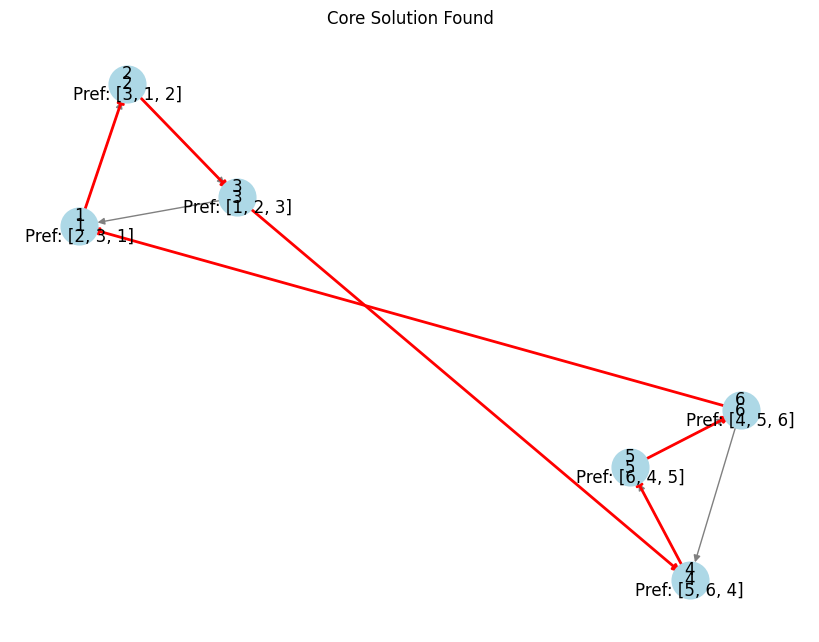

Core Solution: {1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 1}


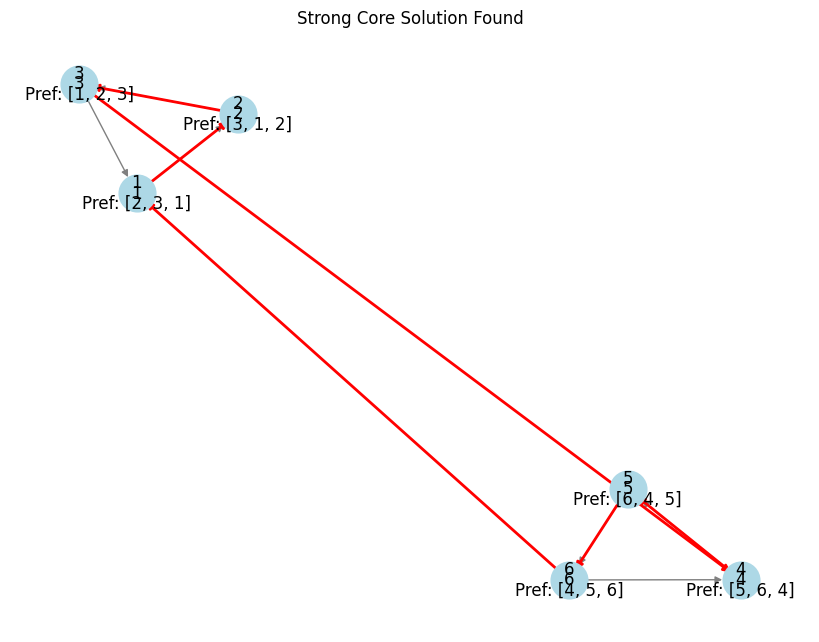

Strong Core Solution: {1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 1}


In [ ]:
G = nx.DiGraph()
G.add_edges_from([
    (1, 2), (2, 3), (3, 1),  # Cycle 1: 1 -> 2 -> 3 -> 1
    (4, 5), (5, 6), (6, 4)   # Cycle 2: 4 -> 5 -> 6 -> 4
])

preferences = {
    1: [2, 3, 1],
    2: [3, 1, 2],
    3: [1, 2, 3],
    4: [5, 6, 4],
    5: [6, 4, 5],
    6: [4, 5, 6]
}
# Display Core solution
core_solution = find_core_solution_with_display(G, preferences)
print("Core Solution:", core_solution)

# Display Strong Core solution
strong_core_solution = find_strong_core_solution_with_display(G, preferences)
print("Strong Core Solution:", strong_core_solution)
